# Do neural networks show brain-like unilateral processing?

In this project, I aim to investigate whether neural networks (NNs) show brain-like unilateral processing. To explore this, I introduce a 'split' encoding model. Unlike the conventional encoding model, the split version uses only one side of NN layers—either the left or the right—to predict fMRI signals. If NNs employ an unilateral processing system, the left NN layers should predict fMRI signals from the right hemisphere in the brain (contralateral prediction) more accurately than the right NN layers (ipsilateral prediction). Furthremore, when NNs perform better in task like image classification, they are more simiar to the brain. So, better NNs are expected to explains the unilateral processing beter. For the project details, please check project presentation slides: [link](https://github.com/yotaKawashima/UnilateralProcessingInCNN/blob/main/Kawashima_20241018_NeuroAISeminar%40FU.pdf).


----
Note: The key component in the above analysis is `extraction_mode` in feature extraction. `extraction_mode` specifies the 'hemisphere' of neural network models from which you extract features. See [2.2. Feature extraction](#scrollTo=CtS-ICcO1agX&line=1&uniqifier=1) for details.





# 1. Set up
This section sets up variables, packages, modules, and paths. You need to change variables depending on your set-ups (e.g. project_dir) in [1.1. Set up variables](#scrollTo=8L1ur7xoZ35-&line=2&uniqifier=1)

## 1.1. Set up variables


In [1]:
project_dir = '/content/drive/MyDrive/Colab Notebooks/ANN_FU/project/'
skip_demo = True # skip step-by-step demo (section 2) if True.
batch_size = 50

## 1.2. Set up packages/modules and mount googld drive



In [2]:
!pip install nilearn==0.9.2
!pip install -q torchinfo

from google.colab import drive
import os
import sys
import torch
import numpy as np
import pandas as pd
from glob import glob
from torchvision.models.feature_extraction import get_graph_node_names

# mount google drive
drive.mount('/content/drive/', force_remount=True)

# add path to the project_dir
sys.path.append(project_dir)

# import custom modules in project_dir
from experiments import full_pipeline, visualization
from utils.roi_mask import get_vertex_idxs_from_rois, all_rois, get_roi_mask, take_mean_within_each_ROI_one_hemi

if skip_demo:
  from models import vision_dnn, feature_extraction
  from experiments import encoding_model, dataset_preparation
  # from utils.roi_mask import all_rois

# check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive/


## 1.3. Set up paths

In [3]:
data_dir = os.path.join(project_dir, 'UvA_encodingtutorial')
# make sure the main dir exists (i.e., check that the above worked)
assert os.path.isdir(data_dir)

fmri_dir = os.path.join(data_dir, 'fmri_data')
stim_dir = os.path.join(data_dir, 'stimuli')
supp_dir = os.path.join(data_dir, 'additional_data')
result_dir = os.path.join(project_dir, 'results')

# Create lists with all image file names, sorted
img_list = sorted(os.listdir(stim_dir))
print('Total n. of images: ' + str(len(img_list)))
imgs_paths = [stim_dir + '/' + x for x in img_list]

Total n. of images: 872


# 2. Analysis (step-by-step demo)
In this demo analysis section, I will go through my analysis on activation in the left 'hemisphere' in the flatten layer from EfficientNet. \

2.1. Model set-up \
2.2. Feature extraction \
2.3. Encoding model (single participant) \
2.4. Encoding model (all participants) \

For the complete analysis for my experiment, go to the next [Analysis (main)](#scrollTo=sZyb2dIQVH1S&line=1&uniqifier=1).  


## 2.1. Model set-up
Set up neural network models and dataloaders.

In [4]:
if not skip_demo:
  # get pre-trained model
  model_name = 'effNet'
  model, transforms = vision_dnn.get_effnet_b0(device)

  # check model architecture and graph node names
  vision_dnn.show_model_summary(model)
  _, eval_node = get_graph_node_names(model)
  print(eval_node)

  # get dataloaders for the model
  dataloader_train, dataloader_test, idxs_train, idxs_test = \
    dataset_preparation.get_dataloaders(imgs_paths, transforms,
                                        device, batch_size,
                                        train_perc=90,
                                        seed=0)

## 2.2. Feature extraction
Extract model features with dimension reduction (PCA). You can specifiy the 'hemisphere' of neural network models by `extraction_mode = 'left' # 'left', 'right', or 'full'`.  Note that the 'full' mode includes both hemispheres.

In [5]:
if not skip_demo:
  # specify model layer and extraction mode (full, right or left)
  extraction_mode = 'left'
  model_layer='flatten'

  # set up feature extractor
  feature_extractor = feature_extraction.FeatureExtractor(model,
                                                          dataloader_train,
                                                          dataloader_test,
                                                          reduction=True,
                                                          n_components=batch_size)

  # set feature extractor
  feature_extractor.set_feature_extractor(model_layer, extraction_mode=extraction_mode)
  # extract features for each dataset
  print("training dataset")
  features_train = feature_extractor.extract_features('train')
  print("testing dataset")
  features_test = feature_extractor.extract_features('test')

## 2.3. Encoding model (single participant)
Fit encoding model and predict fMRI data.

In [6]:
if not skip_demo:
  # perform encoding model (single participant)
  subj = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"]
  subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

  lh_corrs, rh_corrs, _, _ = \
    encoding_model.fit_and_predict(fmri_dir, subj,
                                  features_train, features_test,
                                  idxs_train, idxs_test)

In [7]:
if not skip_demo:
  # visualise the encoding model results
  map_type = 'pial'  #@param ['infl', 'pial', 'sphere', 'white', 'flat']
  hemisphere = 'right'  #@param ['left', 'right']
  roi = "parietal" #@param ["all-vertices", "V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]

  if hemisphere == 'left':
    correlation = lh_corrs
  else:
    correlation = rh_corrs

  view = visualization.plot_brainmap(correlation, roi, map_type, hemisphere, subj_dir)
  view

## 2.4. Encoding model (all participants)
Perform the above encoding model analysis for all participants and obtain across-pariticipants summary.

In [8]:
if not skip_demo:
  rois = ['early', 'ventral']
  prediction_df = \
    encoding_model.fit_and_predict_all_subj(fmri_dir,
                                            features_train, features_test,
                                            idxs_train, idxs_test,
                                            rois, model_name,
                                            model_layer, extraction_mode)

In [9]:
# visualise results
if not skip_demo:
  title = f'Mean correlation from all participants \n \
            model: {model_name}, model_layer: {model_layer}, extraction: {extraction_mode}\n \
            (bar = mean, error bar = std across participants)'
  visualization.make_rois_encoding_plot(prediction_df, title)

In [10]:
# clear all varialbes used in the demo.
if not skip_demo:
  del model, transforms, \
      dataloader_train, dataloader_test, idxs_train, idxs_test, \
      feature_extractor, extraction_mode, model_layer, features_train, features_test, \
      subj, subj_dir, lh_corrs, rh_corrs, \
      map_type, hemisphere, roi, view, \
      rois, prediction_df, title

# 3. Analysis (main)
In this section, I will analyse data and try to answer my research questions. \

[3.1. Comparing three extraction modes: a single participant data](#scrollTo=mCGoTD7Ahero&line=1&uniqifier=1)

[3.2. Comparing three extraction modes: all participants data.](#scrollTo=cK9HGfPQyYZY&line=1&uniqifier=1)

This section calls some functions (e.g. full_pipeline.single_subj_all_cond). \
Basically, they loop [the above demo pipeline](#scrollTo=3UvF7wI2ZG1p&line=1&uniqifier=1) over different models (effNet with/without pretraining), model layers, extraction mode (full, left, and right), and rois.

## 3.1. Comparing three extraction modes: a single participant data

### 3.1.1. Example vertices

I'll foucs on some example vertices in the left hemisphere. I'll check recorded and predicted fMRI data for a set of stimulus images (i.e. test dataset), and compute correlation between them. Here, different extraction modes should give different prediction for the same fMRI data.

Available layers in effNet:
['x', 'features.0', 'features.1.0.block.0', 'features.1.0.block.1', 'features.1.0.block.2', 'features.2.0.block.0', 'features.2.0.block.1', 'features.2.0.block.2', 'features.2.0.block.3', 'features.2.1.block.0', 'features.2.1.block.1', 'features.2.1.block.2', 'features.2.1.block.3', 'features.2.1.stochastic_depth', 'features.2.1.add', 'features.3.0.block.0', 'features.3.0.block.1', 'features.3.0.block.2', 'features.3.0.block.3', 'features.3.1.block.0', 'features.3.1.block.1', 'features.3.1.block.2', 'features.3.1.block.3', 'features.3.1.stochastic_depth', 'features.3.1.add', 'features.4.0.block.0', 'features.4.0.block.1', 'features.4.0.block.2', 'features.4.0.block.3', 'features.4.1.block.0', 'features.4.1.block.1', 'features.4.1.block.2', 'features.4.1.block.3', 'features.4.1.stochastic_depth', 'features.4.1.add', 'features.4.2.block.0', 'features.4.2.block.1', 'features.4.2.block.2', 'features.4.2.block.3', 'features.4.2.stochastic_depth', 'features.4.2.add', 'features.5.0.block.0', 'features.5.0.block.1', 'features.5.0.block.2', 'features.5.0.block.3', 'features.5.1.block.0', 'features.5.1.block.1', 'features.5.1.block.2', 'features.5.1.block.3', 'features.5.1.stochastic_depth', 'features.5.1.add', 'features.5.2.block.0', 'features.5.2.block.1', 'features.5.2.block.2', 'features.5.2.block.3', 'features.5.2.stochastic_depth', 'features.5.2.add', 'features.6.0.block.0', 'features.6.0.block.1', 'features.6.0.block.2', 'features.6.0.block.3', 'features.6.1.block.0', 'features.6.1.block.1', 'features.6.1.block.2', 'features.6.1.block.3', 'features.6.1.stochastic_depth', 'features.6.1.add', 'features.6.2.block.0', 'features.6.2.block.1', 'features.6.2.block.2', 'features.6.2.block.3', 'features.6.2.stochastic_depth', 'features.6.2.add', 'features.6.3.block.0', 'features.6.3.block.1', 'features.6.3.block.2', 'features.6.3.block.3', 'features.6.3.stochastic_depth', 'features.6.3.add', 'features.7.0.block.0', 'features.7.0.block.1', 'features.7.0.block.2', 'features.7.0.block.3', 'features.8', 'avgpool', 'flatten', 'classifier.0', 'classifier.1']


In [11]:
subj = 1 # ["1", "2", "3", "4", "5", "6", "7", "8"]
model_layer_info = [
  {'model_name': 'effNetWithoutPretraining', 'model_layer': 'features.2'},
  {'model_name': 'effNetWithoutPretraining', 'model_layer': 'features.5'},
  {'model_name': 'effNetWithoutPretraining', 'model_layer': 'features.8'},
  {'model_name': 'effNet', 'model_layer': 'features.2'},
  {'model_name': 'effNet', 'model_layer': 'features.5'},
  {'model_name': 'effNet', 'model_layer': 'features.8'},
]
# list of rois where you want to extract vertices from.
rois_list = ["early", "midventral", "ventral"] #["V1v", "V2v", "V3v", "hV4", "ventral"]#['early', 'midventral', 'ventral']

subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

In [12]:
# check roi location and otbain vertex idxs
vertex_idxs, roi_masks = get_vertex_idxs_from_rois(rois_list, subj_dir)

# check the rois
view = visualization.plot_brainmap(roi_masks,
                                   'all-vertices',
                                   'infl', 'left',
                                   subj_dir,
                                   title='roi location')
view

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# try each model_name, model_layer, and extraction_mode for one participant.
force_analysis = False # overwrite result data if True
result_single_subj_path = os.path.join(result_dir, f'prediction_subj{subj:02d}.csv')

# start analysis if force_analysis = Ture or result data do no exist
if force_analysis or not os.path.isfile(result_single_subj_path):
  prediction_single_participant_df = \
    full_pipeline.single_subj_all_cond(fmri_dir, imgs_paths,
                                      device, batch_size,
                                      subj, model_layer_info,
                                      vertex_idxs)
  # save the data
  prediction_single_participant_df.to_pickle(result_single_subj_path)

else: # load result data in the drive folder
  prediction_single_participant_df = pd.read_pickle(result_single_subj_path)

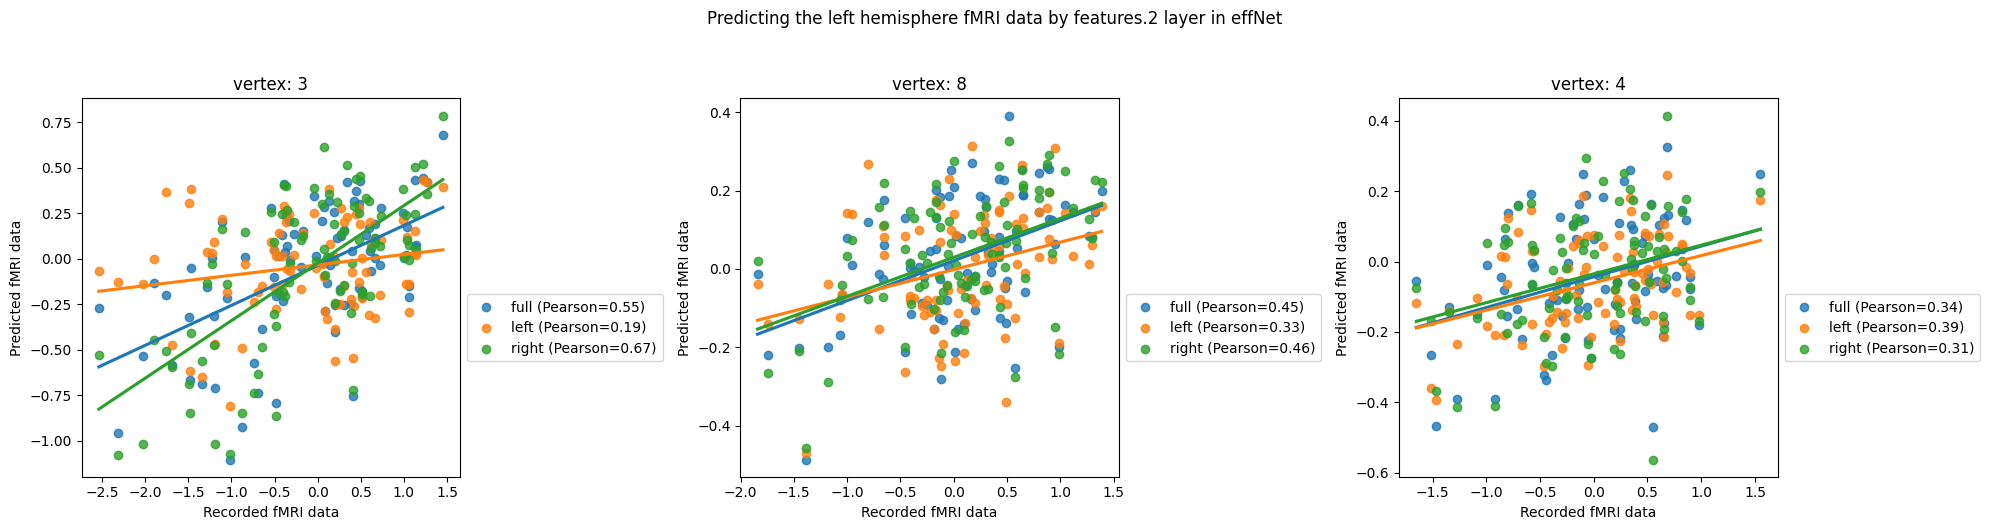

In [14]:
# with pretraining
model_name = 'effNet'
model_layer = 'features.2'
visualization.make_scatter_recorded_predicted_fMRI(prediction_single_participant_df, model_name, model_layer)

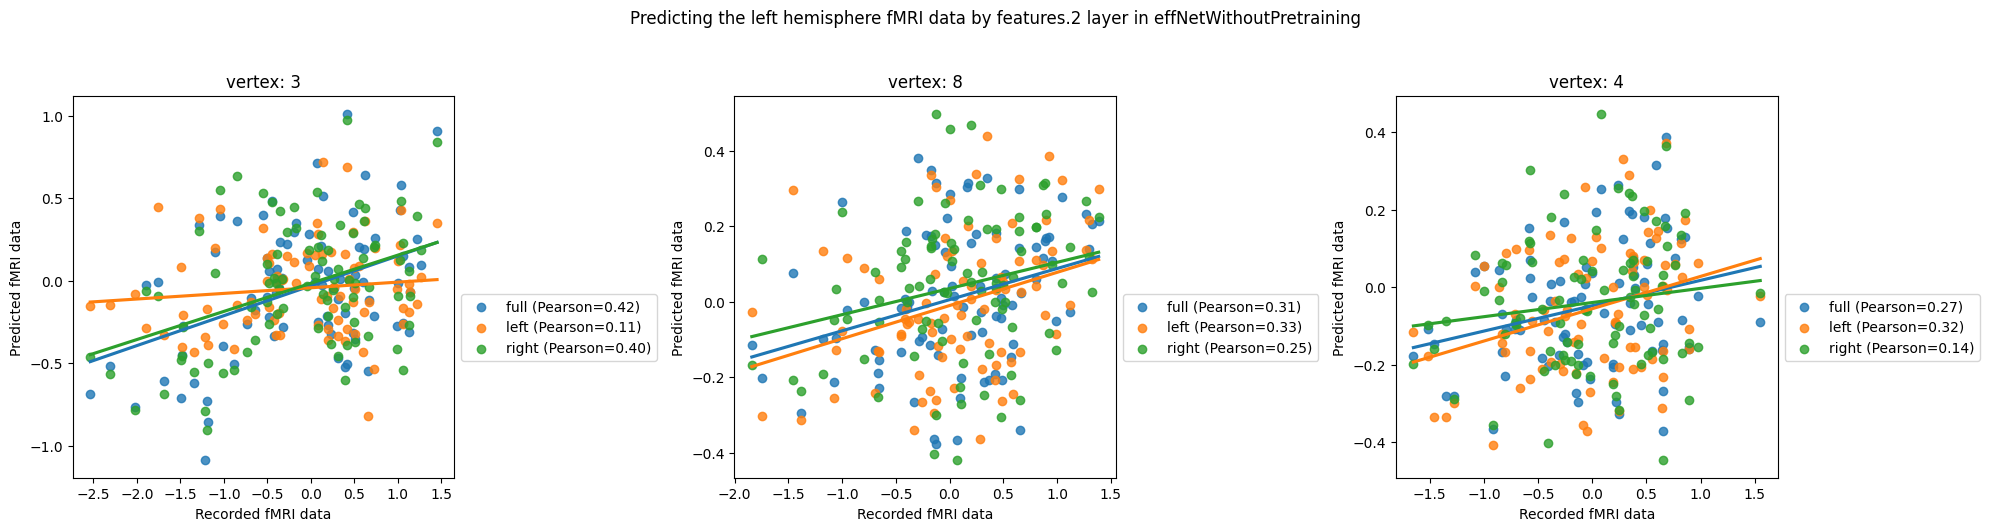

In [15]:
# without pretraining
model_name = 'effNetWithoutPretraining'
model_layer = 'features.2'
visualization.make_scatter_recorded_predicted_fMRI(prediction_single_participant_df, model_name, model_layer)

### 3.1.2. Summary (All verticies)

I'll summarise the results for the left hemisphere fMRI data. I want to check whether the right-side activation patterns in neural network layers are more relevant to the left hemisphere fMRI data than the left-side actiation patterns.

[3.1.2.1. Which extraction mode predicts the left hemisphere better?](#scrollTo=71Z666vbv7-M&line=1&uniqifier=1)

[(optional and revision needed) 3.1.2.2. Which hemisphere does each extraction mode predict better?](#scrollTo=W5CsPFz3wBO5&line=3&uniqifier=1)


#### 3.1.2.1. Which extraction mode predicts the left hemisphere better?
To address this question, I'll compute (lh_corrs from the right extraction mode) - (lh_corrs from the left extraction mode). If contralateral prediction is better than ipsilateral prediction, this should be positive.

In [16]:
# prediction_single_participant_df

In [17]:
# compute (the right extraction mode) - (the left extraction mode)
model_name = 'effNet'
model_layer = 'features.2'
data_right_mode = \
			prediction_single_participant_df[(prediction_single_participant_df.extraction_mode == 'right') &
												(prediction_single_participant_df.model_name == model_name) &
												(prediction_single_participant_df.model_layer == model_layer)]['lh_corrs'].item()

data_left_mode = \
			prediction_single_participant_df[(prediction_single_participant_df.extraction_mode == 'left') &
												(prediction_single_participant_df.model_name == model_name) &
												(prediction_single_participant_df.model_layer == model_layer)]['lh_corrs'].item()

data_cmp_mode = data_right_mode - data_left_mode

In [18]:
# visualization (brain map)
subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')
map_type = 'infl'  #@param ['infl', 'pial', 'sphere', 'white', 'flat']
roi = "all-vertices" #@param ["all-vertices", "V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]
view = visualization.plot_brainmap(data_cmp_mode, roi, map_type, 'left', subj_dir)
view

Output hidden; open in https://colab.research.google.com to view.

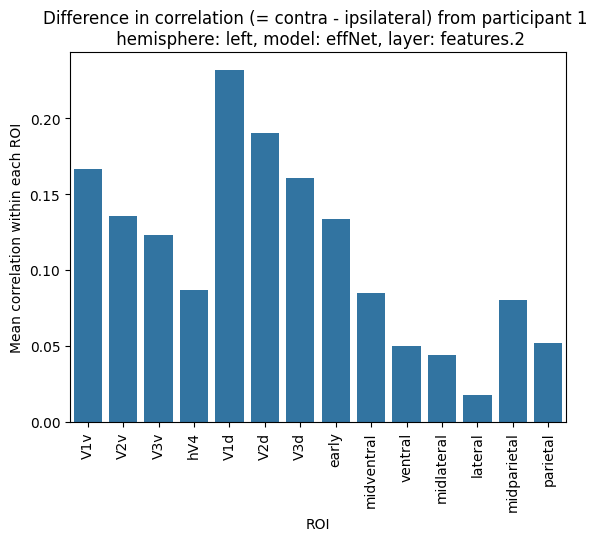

In [19]:
# visualization (bar plot for each roi)
rois = ["V1v", "V2v", "V3v", "hV4",
        "V1d", "V2d", "V3d",
        "early", "midventral",  "ventral",
        "midlateral" , "lateral",
        "midparietal", "parietal"]  # all_rois

# take mean value within each ROI
cmp_mode_df = []
for roi in rois:
    # get mask
    roi_lh_mask, _ = get_roi_mask(roi, 'left', subj_dir)

    # store data
    cmp_mode_df.append({
        'subject': f'subj-{subj:02d}',
        'mean_corr': np.mean(data_cmp_mode[roi_lh_mask!=0]),
        'hemisphere': 'left',
        'roi': roi,
        'model_name' : model_name,
        'model_layer': model_layer,
        'extraction_mode': 'right - left'})

# visualisation
plot_title = f'Difference in correlation (= contra - ipsilateral) from participant {subj} \n hemisphere: left, model: {model_name}, layer: {model_layer}'
visualization.make_rois_encoding_plot(pd.DataFrame(cmp_mode_df), hue=None, title=plot_title)

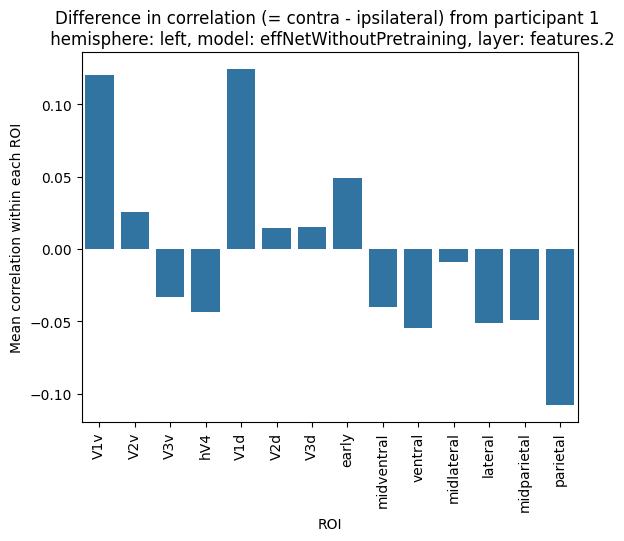

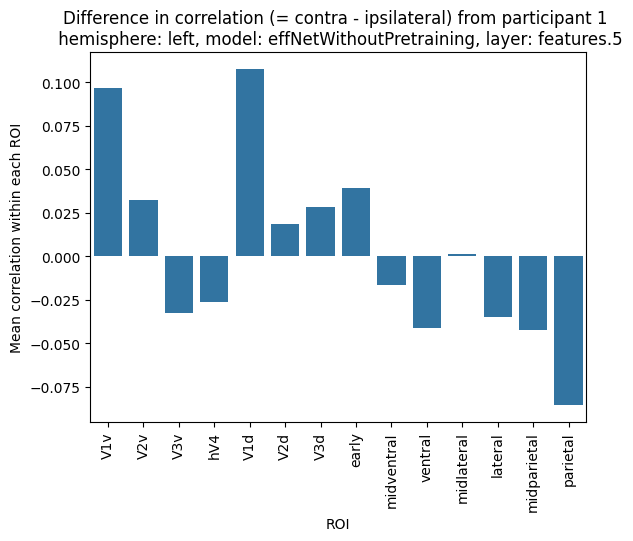

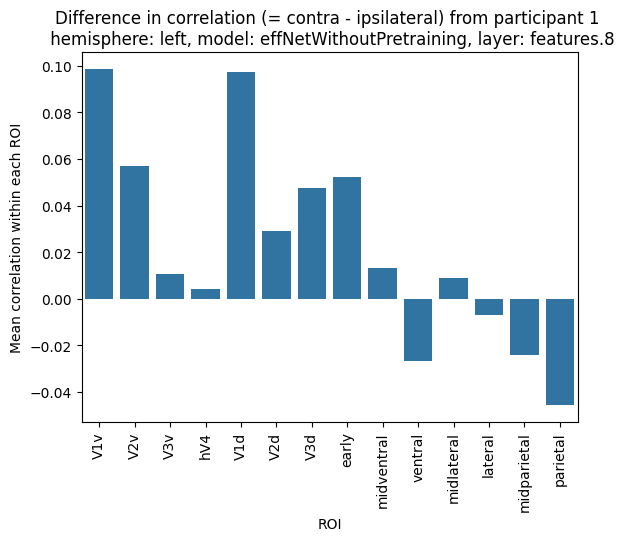

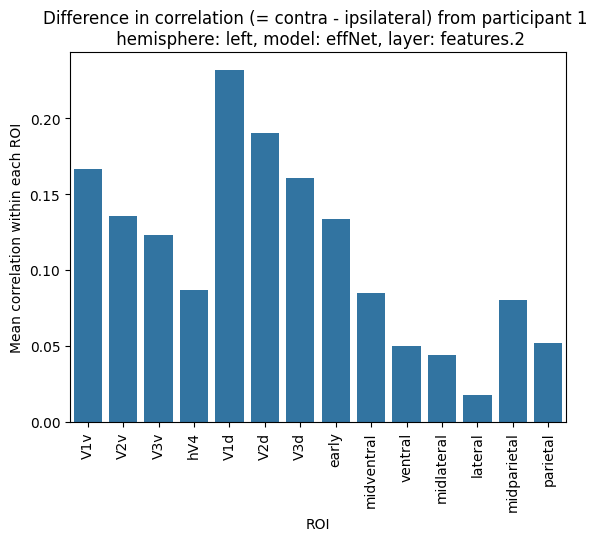

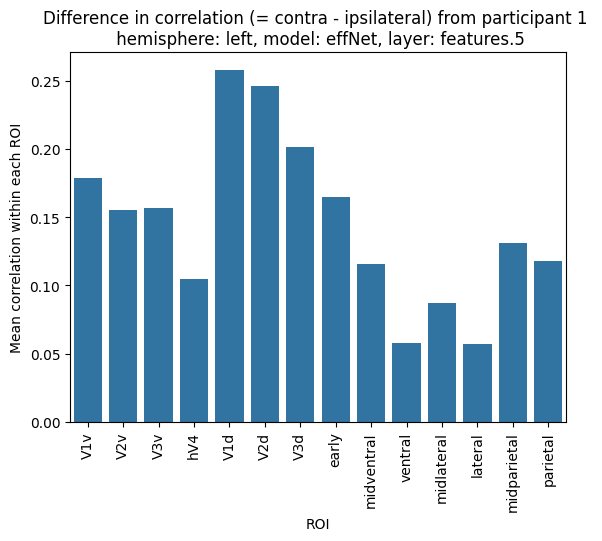

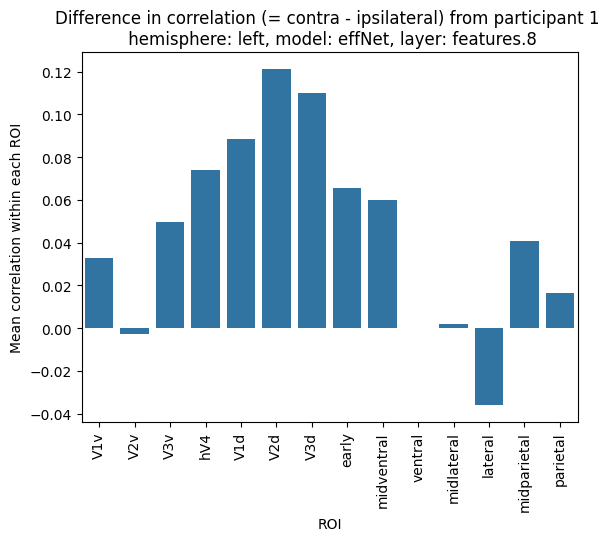

In [20]:
# visualisation (the same bar plot for all models and layers)
for x in model_layer_info:
  model_name = x['model_name']
  model_layer = x['model_layer']
  data_right_mode = \
        prediction_single_participant_df[(prediction_single_participant_df.extraction_mode == 'right') &
                          (prediction_single_participant_df.model_name == model_name) &
                          (prediction_single_participant_df.model_layer == model_layer)]['lh_corrs'].item()

  data_left_mode = \
        prediction_single_participant_df[(prediction_single_participant_df.extraction_mode == 'left') &
                          (prediction_single_participant_df.model_name == model_name) &
                          (prediction_single_participant_df.model_layer == model_layer)]['lh_corrs'].item()

  data_cmp_mode = data_right_mode - data_left_mode

  # take mean value within each ROI
  cmp_mode_df = []
  for roi in rois:
      # get mask
      roi_lh_mask, _ = get_roi_mask(roi, 'left', subj_dir)

      # store data
      cmp_mode_df.append({
          'subject': f'subj-{subj:02d}',
          'mean_corr': np.mean(data_cmp_mode[roi_lh_mask!=0]),
          'hemisphere': 'left',
          'roi': roi,
          'model_name' : model_name,
          'model_layer': model_layer,
          'extraction_mode': 'right - left'})

  # visualisation
  plot_title = f'Difference in correlation (= contra - ipsilateral) from participant {subj} \n hemisphere: left, model: {model_name}, layer: {model_layer}'
  visualization.make_rois_encoding_plot(pd.DataFrame(cmp_mode_df), hue=None, title=plot_title)


#### (optional and revision needed) 3.1.2.2. Which hemisphere does each extraction mode predict better?
To addres this question, I'll compute (mean lh_corrs within ROI) - (mean rh_corrs within ROI) for each extraction mode. Here, the full extraction mode gives us a baseline. Note that you cannot do vertex-wise comparision as the left and right hemisphere have different vertices.

In [21]:
skip_this_section = True
if not skip_this_section:
	model_name = 'effNet'
	model_layer = 'features.5'
	rois = all_rois

	# loop through all extraction modes
	for extraction_mode in ['left', 'right', 'full']:
		rh_corrs = \
					prediction_single_participant_df[(prediction_single_participant_df.extraction_mode == extraction_mode) &
														(prediction_single_participant_df.model_name == model_name) &
														(prediction_single_participant_df.model_layer == model_layer)]['rh_corrs'].item()

		lh_corrs = \
					prediction_single_participant_df[(prediction_single_participant_df.extraction_mode == extraction_mode) &
														(prediction_single_participant_df.model_name == model_name) &
														(prediction_single_participant_df.model_layer == model_layer)]['lh_corrs'].item()

		# take mean with each ROI for eeach hemisphere and
		# subtract the left hemisphere from the right hemisphere
		cmp_hemisphere_df = []
		for roi in rois:
				roi_lh_mask, _ = get_roi_mask(roi, 'left', subj_dir)
				roi_rh_mask, _ = get_roi_mask(roi, 'right', subj_dir)

				cmp_hemisphere_df.append({
						'subject': f'subj-{subj:02d}',
						'mean_corr': np.mean(rh_corrs[roi_rh_mask!=0]) - np.mean(lh_corrs[roi_lh_mask!=0]),
						'hemisphere': 'right - left',
						'roi': roi,
						'model_name' : model_name,
						'model_layer': model_layer,
						'extraction_mode': extraction_mode

				})

		# visualisation (bar plot)
		plot_title = f'Difference in correlation from participant {subj} \n extraction mode: {extraction_mode}, model: {model_name}, layer: {model_layer}'
		visualization.make_rois_encoding_plot(pd.DataFrame(cmp_hemisphere_df), title=plot_title)

## 3.2. Comparing three extraction modes: all participants data.

Finally, I will analyse all participants' data and summarise the results.

I'll summarise the results for the left hemisphere fMRI data. I want to check whether the right-side activation patterns in neural network layers are more relevant to the left hemisphere fMRI data than the left-side actiation patterns.

[3.2.1. Analyse all participants data.](#scrollTo=zUIRJXl1Nntq&line=1&uniqifier=1)\
[3.2.2. Which extraction mode predicts the left hemisphere (or the right hemisphere) better?](#scrollTo=ahwU3iK7OCn1)\
[3.2.3. Supplementary](#scrollTo=-me4t2kcZhmP&line=1&uniqifier=1)


### 3.2.1. Analyse all participants data. (This section takes longer than hour with CPU.)
This section outputs a dataframe that contains correlation data averaged within each ROI for each participant.

In [22]:
# analyse all participants data
force_analysis = False # overwrite result data if True
result_all_subj_path = os.path.join(result_dir, 'prediction_all_subj_df.csv')
rois = all_rois
model_layer_info = [
  {'model_name': 'effNetWithoutPretraining', 'model_layer': 'features.2'},
  {'model_name': 'effNetWithoutPretraining', 'model_layer': 'features.5'},
  {'model_name': 'effNetWithoutPretraining', 'model_layer': 'features.8'},
  {'model_name': 'effNet', 'model_layer': 'features.2'},
  {'model_name': 'effNet', 'model_layer': 'features.5'},
  {'model_name': 'effNet', 'model_layer': 'features.8'},
]

# start analysis if force_analysis = Ture or result data do no exist
if force_analysis or not os.path.isfile(result_all_subj_path):

  prediction_df = \
    full_pipeline.all_subj_all_cond(fmri_dir, imgs_paths,
                                    device, batch_size,
                                    model_layer_info, rois,
                                    extraction_mode_list=['full', 'left', 'right'],
                                    seed=0, train_perc=90)

  # save the data
  prediction_df.to_csv(result_all_subj_path, index=False)

else: # load result data in the drive folder
  prediction_df = pd.read_csv(result_all_subj_path)


### 3.2.2 Which extraction mode predicts the left hemisphere (or the right hemisphere) better?

I will compare correlation between the contralateral and ipsilateral prediction for each participant. To summarise the data, I will compute the difference averaged within each ROI for each participant.

Note:
I will compute \
mean(correlation data from contra. prediction) - mean(correlation data from ipsi. prediction) for each participant. \
Here, mean() takes mean within each ROI. The above subtracion should give the same output as \
mean{(correlation data from contra.) - (correlation data from ipsi.)}.

In [23]:
# initialise dataframe
cmp_mode_all_participant_df = pd.DataFrame([])

# loop through hemisphere to compute (contra.) - (ipsi.)
for hemisphere in  ['left', 'right']:
	# obtain data for each extraction mode (only one hemisphere)
	data_right_mode = \
		prediction_df[(prediction_df.extraction_mode == 'right') &
              		(prediction_df.hemisphere == hemisphere)].reset_index()

	data_left_mode = \
		prediction_df[(prediction_df.extraction_mode == 'left') &
              		(prediction_df.hemisphere == hemisphere)].reset_index()

	# check subjects, rois, model_name and model_layer are ordered in the same way.
	assert (data_right_mode['subject'] == data_left_mode['subject']).to_list
	assert (data_right_mode['roi'] == data_left_mode['roi']).tolist()
	assert (data_right_mode['model_name'] == data_left_mode['model_name']).tolist()
	assert (data_right_mode['model_layer'] == data_left_mode['model_layer']).tolist()

	# compute (contra.) - (ipsi.) regardless of hemisphere.
	if hemisphere == 'left':
		data_cmp_mode = data_right_mode['mean_corr'] - data_left_mode['mean_corr']
		extraction_mode = 'right - left'
	elif hemisphere == 'right':
		data_cmp_mode = data_left_mode['mean_corr'] - data_right_mode['mean_corr']
		extraction_mode = 'left - right'

	# copy dataframe info and update mean_corr and extraction_mode
	cmp_mode_all_participant_df_tentative = \
		prediction_df[(prediction_df.extraction_mode == 'right') &
              		(prediction_df.hemisphere == hemisphere)].copy(deep=True).reset_index()
	cmp_mode_all_participant_df_tentative['mean_corr'] = data_cmp_mode
	cmp_mode_all_participant_df_tentative['extraction_mode'] = extraction_mode

	# store data
	cmp_mode_all_participant_df = \
		pd.concat([cmp_mode_all_participant_df, cmp_mode_all_participant_df_tentative],
		          ignore_index=True)

In [24]:
# rois to plot
rois_to_plot = ["V1v", "V2v", "V3v", "hV4",
        "V1d", "V2d", "V3d",
        "early", "midventral",  "ventral",
        "midlateral" , "lateral",
        "midparietal", "parietal"]  # all_rois

# y-axis range of bar plot
plot_range = [-0.05, 0.18]# None

Compare rois for each layer in effNet


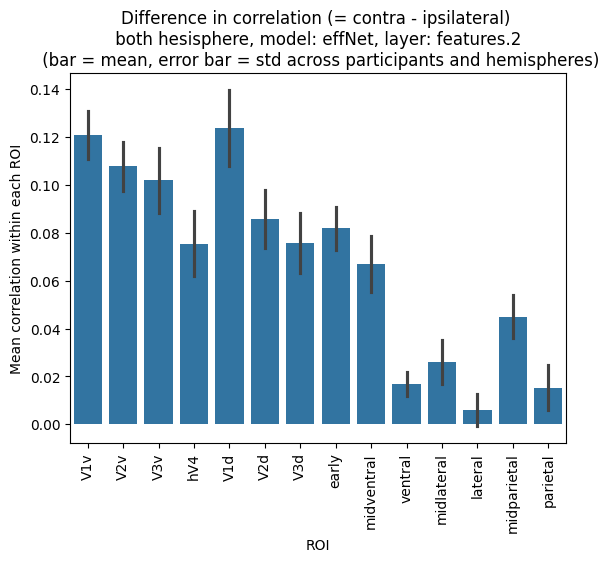

In [25]:
# visualise data for left hemispher only
# hemisphere = 'left'
# model_name = 'effNet'
# model_layer = 'features.2'

# plot_title = f'Difference in correlation (= contra - ipsilateral) \n hesisphere: {hemisphere}, model: {model_name}, layer: {model_layer} \n (bar = mean, error bar = std across participants)'
# data_to_plot = \
#   cmp_mode_all_participant_df[
#       (cmp_mode_all_participant_df.roi.isin(rois_to_plot)) &
#       (cmp_mode_all_participant_df.hemisphere == hemisphere) &
#       (cmp_mode_all_participant_df.model_name == model_name) &
#       (cmp_mode_all_participant_df.model_layer == model_layer)
#       ]
# visualization.make_rois_encoding_plot(data_to_plot, hue=None, title=plot_title, plot_range=None)


# visualise the whole brain data (mean across participants and hemispheres)
model_name = 'effNet'
model_layer = 'features.2'

plot_title = f'Difference in correlation (= contra - ipsilateral) \n both hesisphere, model: {model_name}, layer: {model_layer} \n (bar = mean, error bar = std across participants and hemispheres)'
data_to_plot = \
  cmp_mode_all_participant_df[
      (cmp_mode_all_participant_df.roi.isin(rois_to_plot)) &
      (cmp_mode_all_participant_df.model_name == model_name) &
      (cmp_mode_all_participant_df.model_layer == model_layer)
      ]
visualization.make_rois_encoding_plot(data_to_plot, hue=None, title=plot_title, plot_range=None)

Compare layers for each model

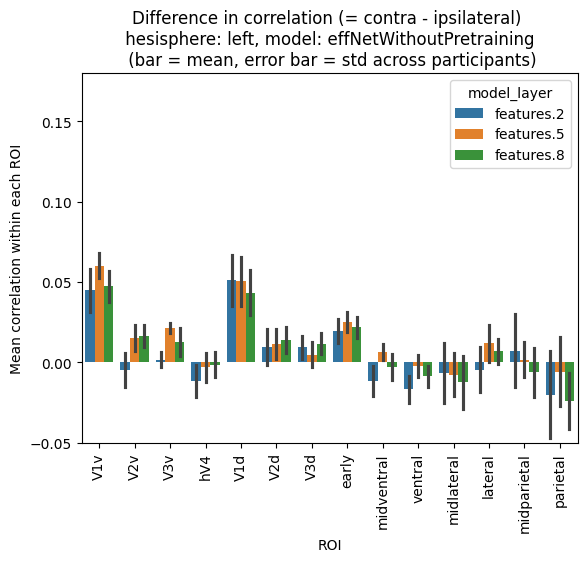

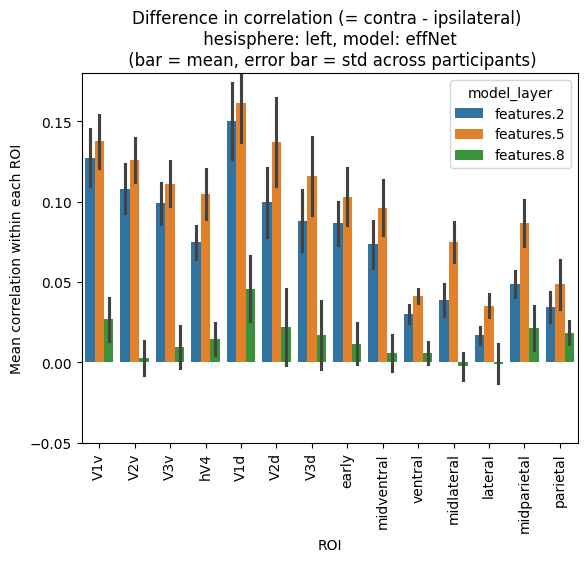

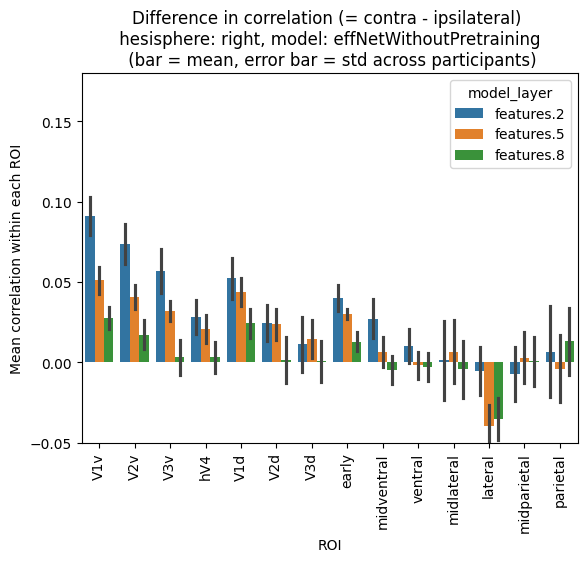

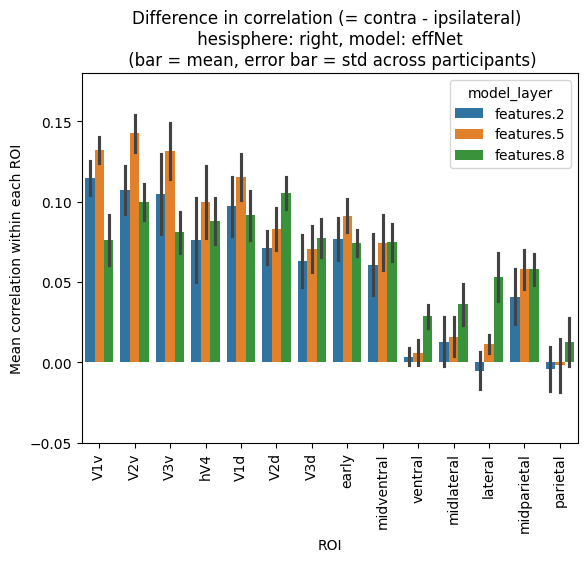

In [26]:
# visualise data for each hemisphere separately (mean across participants)
for hemisphere in  ['left', 'right']:
  for model_name in pd.DataFrame(model_layer_info)['model_name'].unique():
    plot_title = f'Difference in correlation (= contra - ipsilateral) \n hesisphere: {hemisphere}, model: {model_name} \n (bar = mean, error bar = std across participants)'
    data_to_plot = \
      cmp_mode_all_participant_df[
          (cmp_mode_all_participant_df.roi.isin(rois_to_plot)) &
          (cmp_mode_all_participant_df.hemisphere == hemisphere) &
          (cmp_mode_all_participant_df.model_name == model_name)
          ]
    visualization.make_rois_encoding_plot(data_to_plot, hue='model_layer', title=plot_title, plot_range=plot_range)

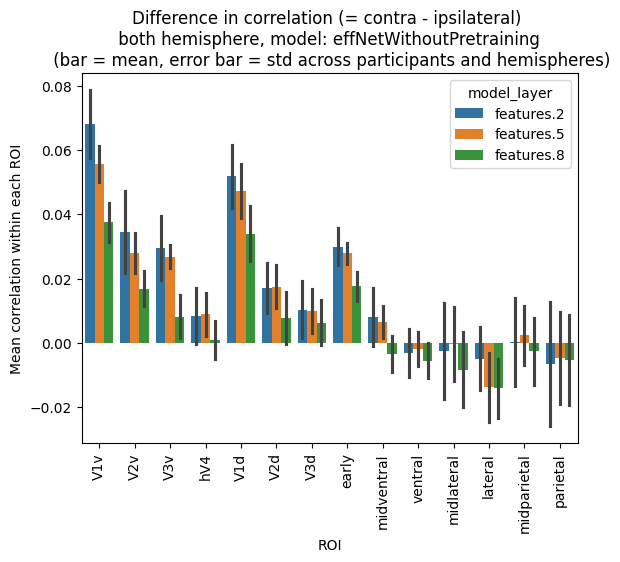

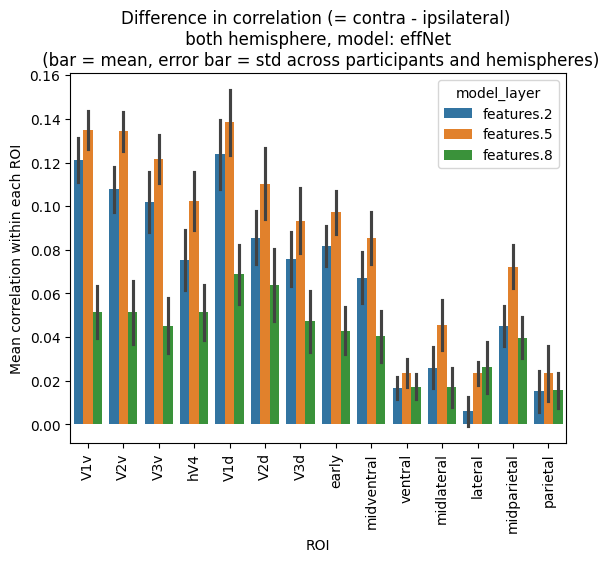

In [27]:
# visualise the whole brain data (mean across participants and hemispheres)
for model_name in pd.DataFrame(model_layer_info)['model_name'].unique():
  plot_title = f'Difference in correlation (= contra - ipsilateral) \n both hemisphere, model: {model_name} \n (bar = mean, error bar = std across participants and hemispheres)'
  data_to_plot = \
    cmp_mode_all_participant_df[
        (cmp_mode_all_participant_df.roi.isin(rois_to_plot)) &
        (cmp_mode_all_participant_df.model_name == model_name)
        ]
  visualization.make_rois_encoding_plot(data_to_plot, hue='model_layer', title=plot_title)

Compare models for each model layer.

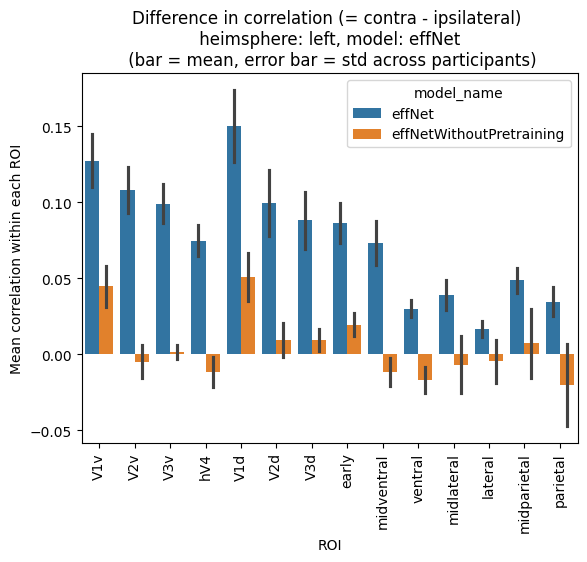

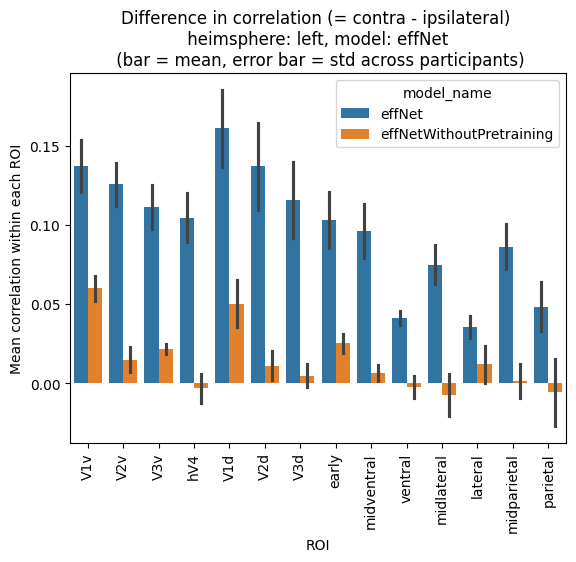

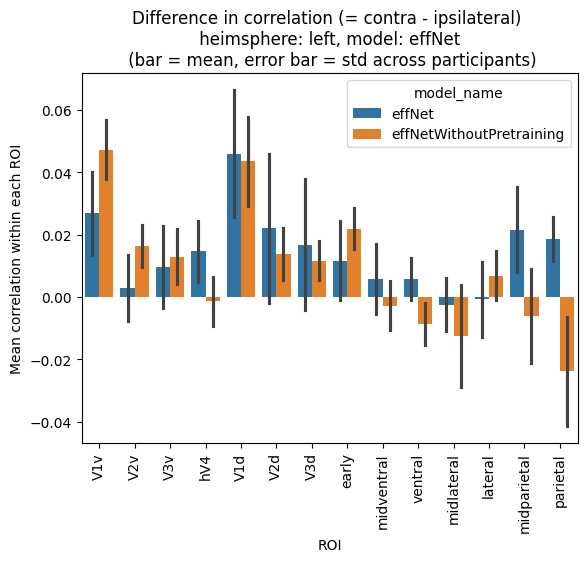

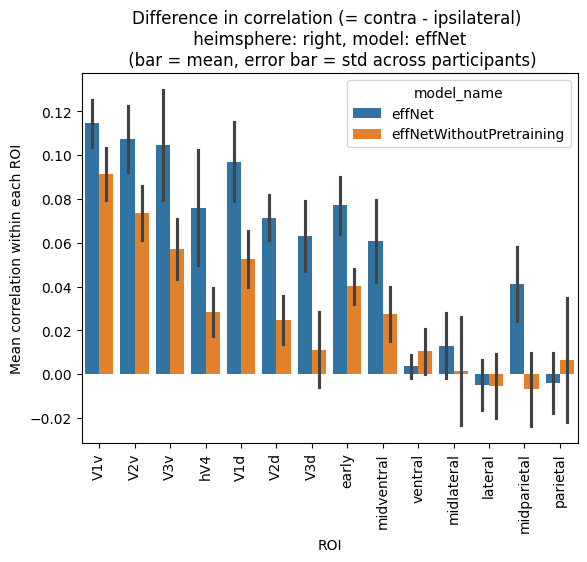

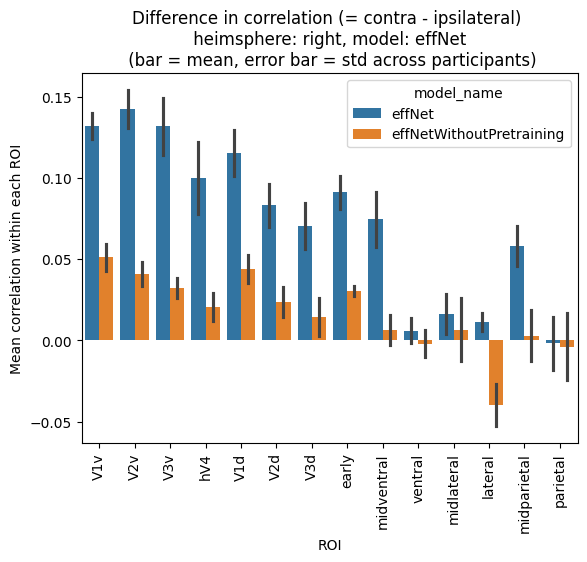

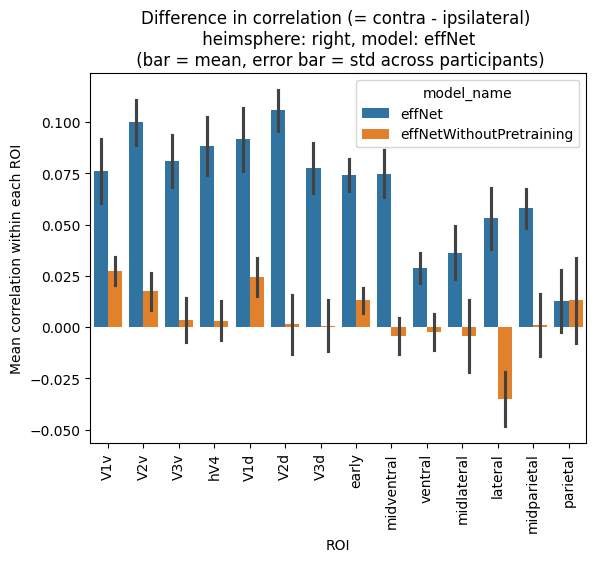

In [28]:
# Visualise data for each hemisphere separately (mean across participants)
for hemisphere in ['left', 'right']:
  for model_layer in pd.DataFrame(model_layer_info)['model_layer'].unique():
    plot_title = f'Difference in correlation (= contra - ipsilateral) \n heimsphere: {hemisphere}, model: {model_name} \n (bar = mean, error bar = std across participants)'
    data_to_plot = \
      cmp_mode_all_participant_df[
          (cmp_mode_all_participant_df.roi.isin(rois_to_plot)) &
          (cmp_mode_all_participant_df.hemisphere == hemisphere) &
          (cmp_mode_all_participant_df.model_layer == model_layer)
          ]
    # order rows in the dataframe for better visualisation.
    data_to_plot = data_to_plot.sort_values(['model_name','index'])
    # make plot
    visualization.make_rois_encoding_plot(data_to_plot, hue='model_name', title=plot_title)

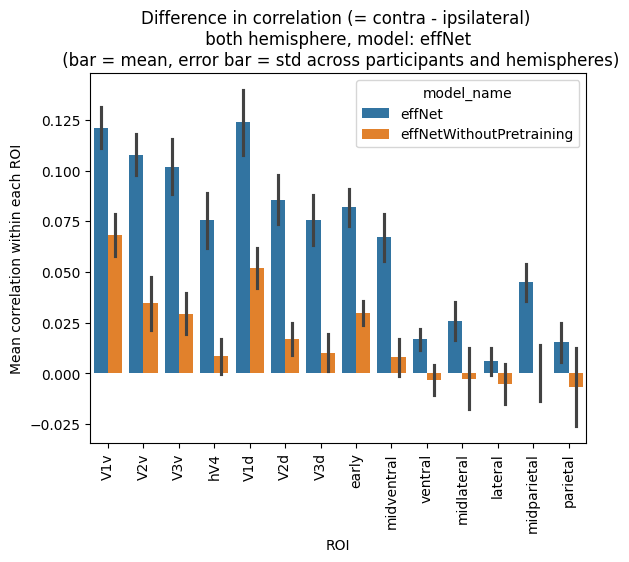

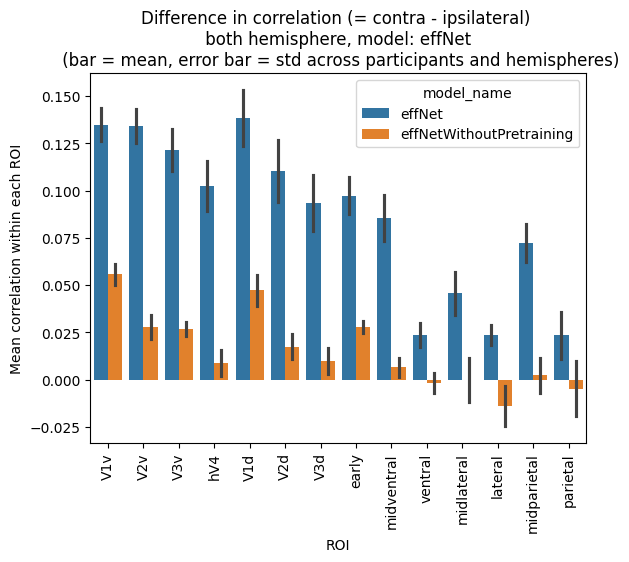

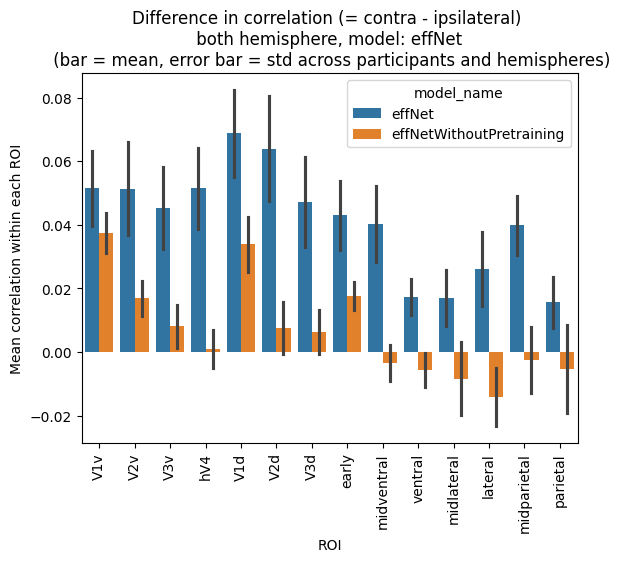

In [29]:
# Visualise the whole brain data (mean across participants and hemispheres)
for model_layer in pd.DataFrame(model_layer_info)['model_layer'].unique():
  plot_title = f'Difference in correlation (= contra - ipsilateral) \n both hemisphere, model: {model_name} \n (bar = mean, error bar = std across participants and hemispheres)'
  data_to_plot = \
    cmp_mode_all_participant_df[
        (cmp_mode_all_participant_df.roi.isin(rois_to_plot)) &
        (cmp_mode_all_participant_df.model_layer == model_layer)
        ]
  # order rows in the dataframe for better visualisation.
  data_to_plot = data_to_plot.sort_values(['model_name','index'])
  # make plot
  visualization.make_rois_encoding_plot(data_to_plot, hue='model_name', title=plot_title)

### 3.2.3. Supplementary

Check encoding model performance for the full model.


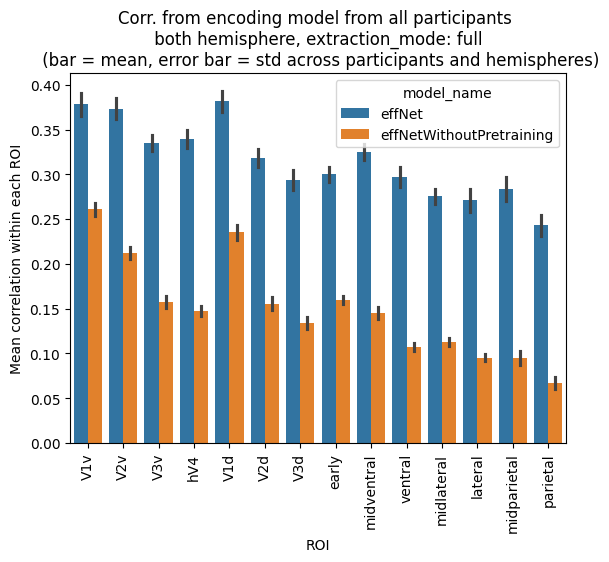

In [30]:
extraction_mode = 'full'

# visualise the whole brain data (mean across participants and hemisphers)
# obtain data for each extraction mode (only one hemisphere)
data_to_plot = \
  prediction_df[(prediction_df.roi.isin(rois_to_plot)) &
                (prediction_df.extraction_mode == extraction_mode)
                ].reset_index()

plot_title = f'Corr. from encoding model from all participants \n both hemisphere, extraction_mode: {extraction_mode} \n (bar = mean, error bar = std across participants and hemispheres)'
# order rows in the dataframe for better visualisation.
data_to_plot = data_to_plot.sort_values(['model_name','index'])
# make plot
visualization.make_rois_encoding_plot(data_to_plot, hue='model_name', title=plot_title)

# visualise data for each hemisphere separately
# for hemisphere in  ['left', 'right']:
#   # obtain data for each extraction mode (only one hemisphere)
#   data_to_plot = \
#     prediction_df[(cmp_mode_all_participant_df.roi.isin(rois_to_plot)) &
#                   (prediction_df.hemisphere == hemisphere) &
#                   (prediction_df.extraction_mode == extraction_mode)
#                   ].reset_index()

#   plot_title = f'Corr. from encoding model from all participants \n hemisphere: {hemisphere}, extraction_mode: {extraction_mode} \n (bar = mean, error bar = std across participants)'
#   # order rows in the dataframe for better visualisation.
#   data_to_plot = data_to_plot.sort_values(['model_name','index'])
#   # make plot
#   visualization.make_rois_encoding_plot(data_to_plot, hue='model_name', title=plot_title)

Compare hemisphers for each layer in effNet.

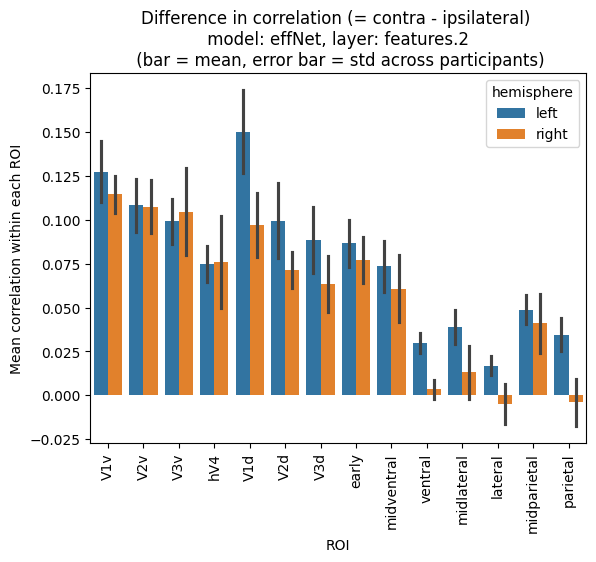

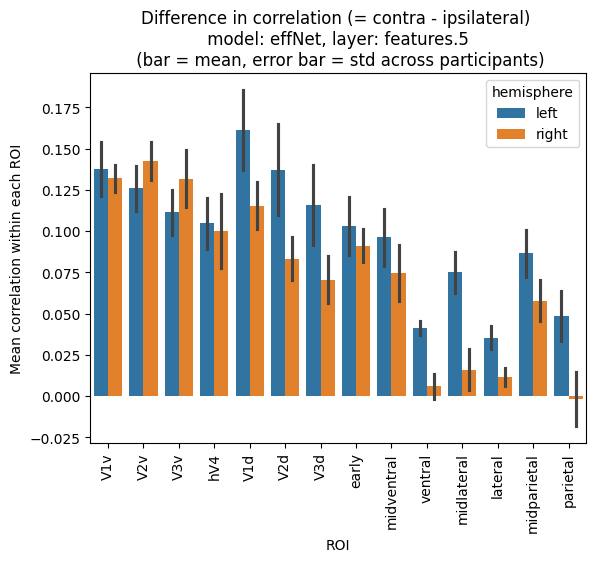

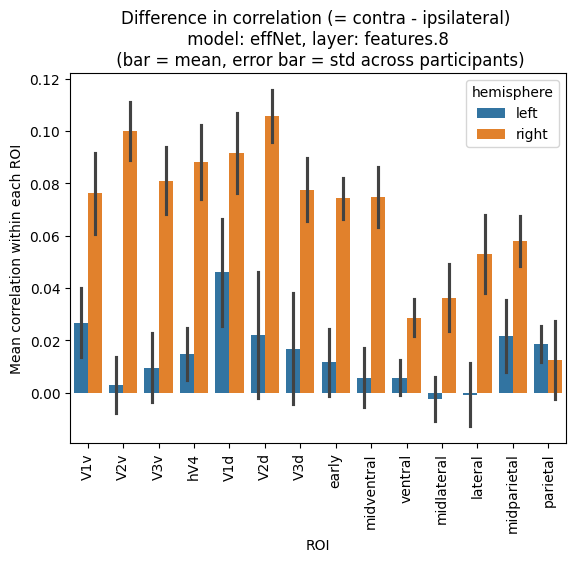

In [31]:
# visualise the whole brain data (mean across participants and hemispheres)
model_name = 'effNet'

for model_layer in pd.DataFrame(model_layer_info)['model_layer'].unique():
  plot_title = f'Difference in correlation (= contra - ipsilateral) \n model: {model_name}, layer: {model_layer} \n (bar = mean, error bar = std across participants)'
  data_to_plot = \
    cmp_mode_all_participant_df[
        (cmp_mode_all_participant_df.roi.isin(rois_to_plot)) &
        (cmp_mode_all_participant_df.model_name == model_name) &
        (cmp_mode_all_participant_df.model_layer == model_layer)
        ]
  visualization.make_rois_encoding_plot(data_to_plot, hue='hemisphere', title=plot_title, plot_range=None)

# optional (not ready yet)


Try half-trained model.